In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir(r'/storage/users/g-and-n/visual_models_results')

In [3]:
def extract_final_results(model, reload_df=False):
    os.makedirs(f'final_results/{model}/errors', exist_ok=True)
    
    if reload_df:
        for j in tqdm(range(1, 36)):
            exist = False

            dfs = []
            for i, chan in enumerate(['AGP', 'DNA', 'ER', 'Mito', 'RNA']):
                chan_num = (i+1)*100

                csv_path = fr'{chan_num+j}/{model}/channel {chan}/results.csv'

                df = pd.read_csv(csv_path, index_col=list(range(6))).rename({'PCC':f'{chan}_PCC','MSE':f'{chan}_MSE'}, axis=1) 
                dfs.append(df)

            df = pd.concat(dfs, axis=1)
            plate_num = df.index.get_level_values(0).unique().to_list()
            if len(plate_num) != 1:
                raise 'Not one plate per experiment'

            plate_num = plate_num[0]
            df.to_csv(fr'final_results/{model}/errors/{plate_num}.csv')
            del df
    
    csvs_path = glob(fr'final_results/{model}/errors/*.csv')
    csvs = {os.path.basename(csv_path): pd.read_csv(csv_path, index_col=list(range(6))) for csv_path in csvs_path}
    return csvs

models_csvs = {model: extract_final_results(model, False) for model in ['AUTO1T01', 'UNET4TO1']}        
    

In [4]:
[len(j) for i,j in models_csvs.items()]

[35, 35]

In [5]:
def extract_zscores_visual(vis_res_path, p):
    os.makedirs(fr'{vis_res_path}/zscores', exist_ok=True)
    zscore_path = fr'{vis_res_path}/zscores/{p}'
    if os.path.exists(zscore_path):
        return pd.read_csv(zscore_path, index_col=list(range(4)))
    
    
    df = pd.read_csv(fr'{vis_res_path}/errors/{p}', index_col=list(range(6)))

    df = df.groupby(['Plate','Well_Role','Well','Broad_Sample']).mean()

    pcc_all = df.filter(regex='_PCC', axis=1).mean(axis=1)
    pcc_all.name = 'ALL_PCC'
    mse_all = df.filter(regex='_MSE', axis=1).mean(axis=1)
    mse_all.name = 'ALL_MSE'

    df = pd.concat([df,pcc_all,mse_all], axis=1)

    df_mock = df.query('Well_Role == "mock"')
    scaler = StandardScaler()
    scaler.fit(df_mock)
    del df_mock

    df_zscores = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    del df
    df_zscores.to_csv(zscore_path)
    
    return df_zscores

In [6]:
res = {model: [extract_zscores_visual(fr'final_results/{model}', p) for p in os.listdir(fr'final_results/{model}/errors')] for model in ['AUTO1T01', 'UNET4TO1']}

In [7]:
res = {k: pd.concat(csvs) for k, csvs in res.items()}

In [8]:
final_res = res['UNET4TO1'].join(res['AUTO1T01'], lsuffix='_4to1', rsuffix='_1to1')
final_res

AGP_PCC_4to1  AGP_MSE_4to1  \
Plate Well_Role Well Broad_Sample                                         
24792 mock      a13  DMSO                       -0.131277     -0.709681   
                a14  DMSO                        0.984979     -0.704546   
                b13  DMSO                       -0.284175     -0.569370   
                b14  DMSO                       -0.720114     -0.435659   
                c11  DMSO                        0.681533     -0.489390   
...                                                   ...           ...   
24661 treated   p20  BRD-K89697867-001-01-2      1.486042      1.102040   
                p21  BRD-K72872827-001-01-9     -3.195318    140.548321   
                p22  BRD-K79106177-001-01-1      0.050999      2.537754   
                p23  BRD-K69880993-001-01-5      0.344582      4.645240   
                p24  BRD-K22246751-001-01-7      0.870301      1.568818   

                                             DNA_PCC_4to1  DNA_MSE_4to1  \
Plate Well_Role Well Broad_Sample                                         
24792 mock      a13  DMSO                       -1.718135     -0.725308   
                a14  DMSO                       -2.186123     -0.748179   
                b13  DMSO                       -0.266972     -0.624880   
                b14  DMSO                        0.112617     -0.510510   
                c11  DMSO                        0.996648     -0.409456   
...                                                   ...           ...   
24661 treated   p20  BRD-K89697867-001-01-2     -0.212639     -0.149486   
                p21  BRD-K72872827-001-01-9     -6.249173      3.767127   
                p22  BRD-K79106177-001-01-1    -15.418912      8.991241   
                p23  BRD-K69880993-001-01-5     -1.586832      0.000738   
                p24  BRD-K22246751-001-01-7     -0.222289     -0.112139   

                                             ER_PCC_4to1  ER_MSE_4to1  \
Plate Well_Role Well Broad_Sample                                       
24792 mock      a13  DMSO                      -0.603417     0.526219   
                a14  DMSO                      -0.310503     0.023251   
                b13  DMSO                      -0.612519    -0.263467   
                b14  DMSO                      -0.122030    -0.270591   
                c11  DMSO                      -0.155054    -0.335732   
...                                                  ...          ...   
24661 treated   p20  BRD-K89697867-001-01-2     0.452701    -0.853636   
                p21  BRD-K72872827-001-01-9   -10.367789    41.672749   
                p22  BRD-K79106177-001-01-1    -1.539475     8.552387   
                p23  BRD-K69880993-001-01-5   -10.838316    14.835099   
                p24  BRD-K22246751-001-01-7     0.173882    -0.980564   

                                             Mito_PCC_4to1  Mito_MSE_4to1  \
Plate Well_Role Well Broad_Sample                                           
24792 mock      a13  DMSO                        -0.247211      -0.627674   
                a14  DMSO                        -0.744367      -0.784739   
                b13  DMSO                         0.578739      -0.720295   
                b14  DMSO                         0.316773      -0.509056   
                c11  DMSO                        -0.005855      -0.330360   
...                                                    ...            ...   
24661 treated   p20  BRD-K89697867-001-01-2       1.688836      -0.450945   
                p21  BRD-K72872827-001-01-9      -3.080414      69.342862   
                p22  BRD-K79106177-001-01-1      -3.497533       1.822632   
                p23  BRD-K69880993-001-01-5      -1.013403      -0.092981   
                p24  BRD-K22246751-001-01-7       0.384867      -0.987940   

                                             RNA_PCC_4to1  RNA_MSE_4to1  ...  \
Plate Well_Role Well Broad_Sample                            

In [9]:
final_trts = final_res.query('Well_Role != "mock"')
final_trts.index = final_trts.index.droplevel([1,2])
final_trts

AGP_PCC_4to1  AGP_MSE_4to1  DNA_PCC_4to1  \
Plate Broad_Sample                                                       
24792 BRD-K25512917-001-01-0      1.124655      0.495083     -0.620889   
      BRD-K15444424-001-01-4      2.260974     -0.333697      0.199720   
      BRD-K35088248-001-01-9      1.544360     -0.338333      1.825432   
      BRD-K15792876-001-01-9      2.803465     -0.716515      1.257638   
      BRD-K11487484-001-01-4      2.973976     -0.743210     -0.783805   
...                                    ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.486042      1.102040     -0.212639   
      BRD-K72872827-001-01-9     -3.195318    140.548321     -6.249173   
      BRD-K79106177-001-01-1      0.050999      2.537754    -15.418912   
      BRD-K69880993-001-01-5      0.344582      4.645240     -1.586832   
      BRD-K22246751-001-01-7      0.870301      1.568818     -0.222289   

                              DNA_MSE_4to1  ER_PCC_4to1  ER_MSE_4to1  \
Plate Broad_Sample                                                     
24792 BRD-K25512917-001-01-0      1.374876     0.773558    -0.149477   
      BRD-K15444424-001-01-4      0.370263     0.757169    -0.260365   
      BRD-K35088248-001-01-9     -0.193957     1.014697    -0.192510   
      BRD-K15792876-001-01-9     -0.621994     0.884223    -0.201394   
      BRD-K11487484-001-01-4     -0.705443     0.060129    -0.101173   
...                                    ...          ...          ...   
24661 BRD-K89697867-001-01-2     -0.149486     0.452701    -0.853636   
      BRD-K72872827-001-01-9      3.767127   -10.367789    41.672749   
      BRD-K79106177-001-01-1      8.991241    -1.539475     8.552387   
      BRD-K69880993-001-01-5      0.000738   -10.838316    14.835099   
      BRD-K22246751-001-01-7     -0.112139     0.173882    -0.980564   

                              Mito_PCC_4to1  Mito_MSE_4to1  RNA_PCC_4to1  \
Plate Broad_Sample                                                         
24792 BRD-K25512917-001-01-0      -0.453550       2.813984     -0.566209   
      BRD-K15444424-001-01-4       0.677377       0.853984      1.733558   
      BRD-K35088248-001-01-9       0.397206       0.165966      0.761404   
      BRD-K15792876-001-01-9       0.831974      -0.586837      2.173650   
      BRD-K11487484-001-01-4      -0.256511      -0.804778      2.506914   
...                                     ...            ...           ...   
24661 BRD-K89697867-001-01-2       1.688836      -0.450945      1.416662   
      BRD-K72872827-001-01-9      -3.080414      69.342862     -0.555696   
      BRD-K79106177-001-01-1      -3.497533       1.822632     -3.185687   
      BRD-K69880993-001-01-5      -1.013403      -0.092981      0.277528   
      BRD-K22246751-001-01-7       0.384867      -0.987940      0.210619   

                              RNA_MSE_4to1  ...  DNA_PCC_1to1  DNA_MSE_1to1  \
Plate Broad_Sample                          ...                               
24792 BRD-K25512917-001-01-0      1.440060  ...     -0.885797     -0.903881   
      BRD-K15444424-001-01-4     -0.085241  ...     -0.925360     -0.835524   
      BRD-K35088248-001-01-9     -0.102222  ...      0.416739     -0.939241   
      BRD-K15792876-001-01-9     -0.749602  ...      0.462707     -2.036241   
      BRD-K11487484-001-01-4     -0.784035  ...     -3.021189     -1.476898   
...                                    ...  ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.482691  ...      1.079050     -1.437115   
      BRD-K72872827-001-01-9    214.368469  ...     -8.494681     24.195046   
      BRD-K79106177-001-01-1      8.667292  ...      0.697963      9.010067   
      BRD-K69880993-001-01-5      6.447281  ...     -0.078830      1.208960   
      BRD-K22246751-001-01-7      0.385827  ...      0.581944     -0.761878   

                              ER_PCC_1to1  ER_MSE_1to1  Mito_PCC_1to1  \
Plate Broad_Sample                      

In [10]:
trts = final_trts

In [26]:
trts = final_trts.query(f'ALL_PCC_4to1 <=-9 or ALL_PCC_1to1 <=-9')

In [37]:
trts = final_trts.query(f'ALL_MSE_4to1 >=5 or ALL_MSE_1to1 >=5')

In [12]:
combins = [('MSE', '4to1', 'MSE', '1to1'),
           ('PCC', '4to1', 'PCC', '1to1'),
           ('PCC', '4to1', 'MSE', '4to1'),
           ('PCC', '1to1', 'MSE', '1to1')]

In [27]:
f'{kind_y}-{metric_y}({kind_x}-{metric_x}).eps'

'4to1-PCC(4to1-MSE).eps'

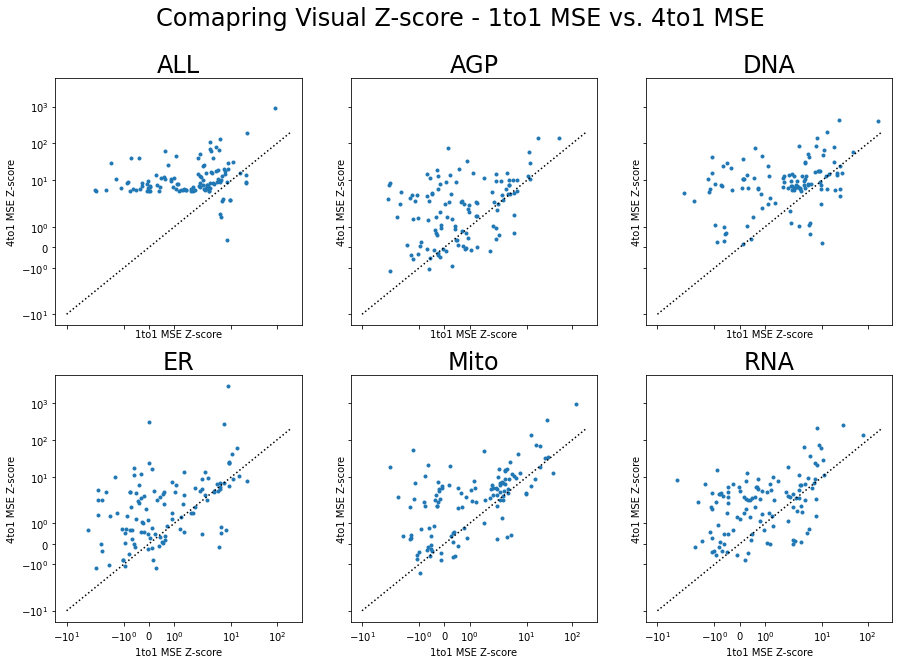

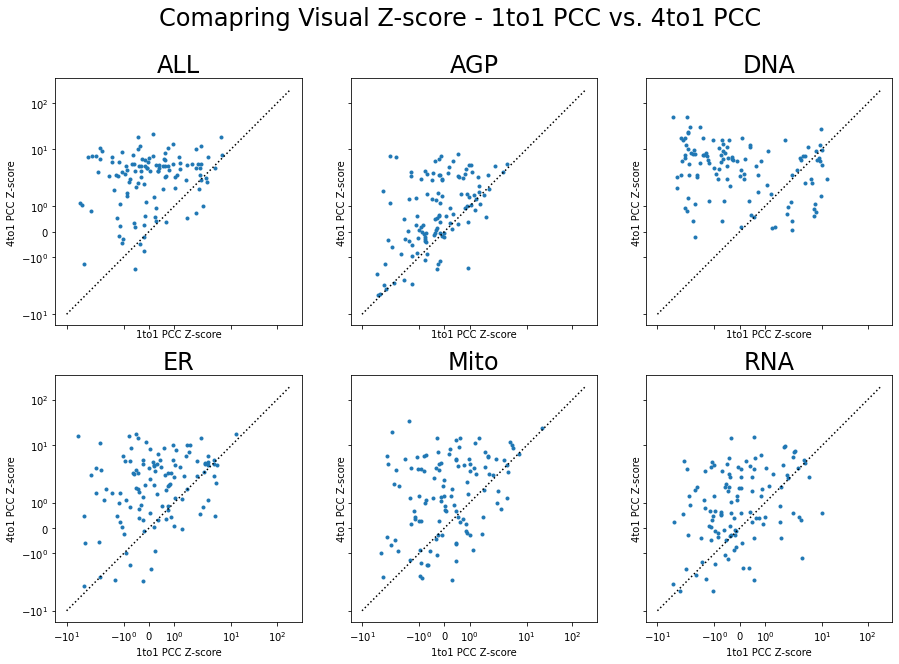

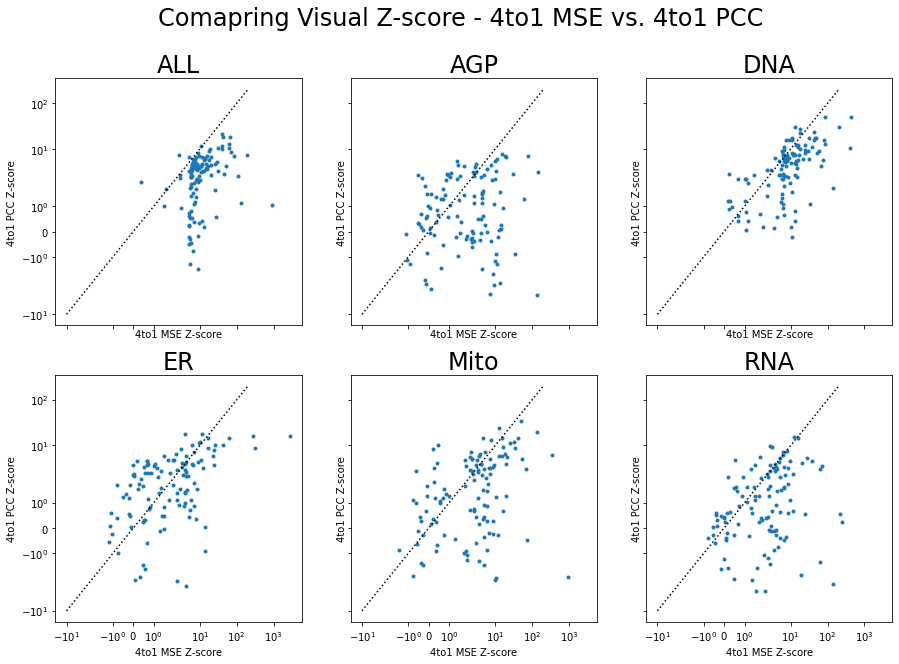

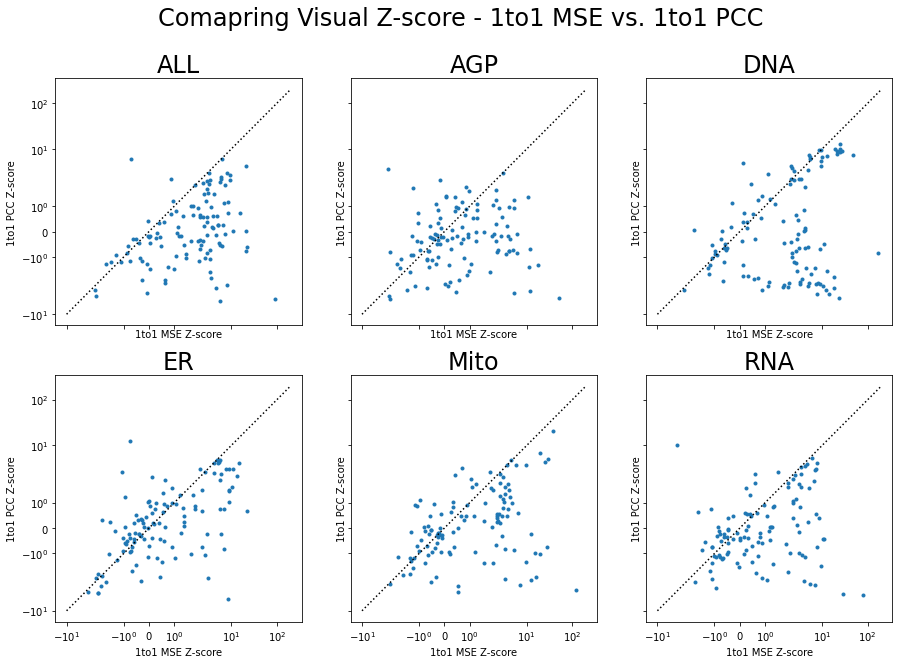

In [38]:
nrows = 2
ncols = 3

for metric_y, kind_y, metric_x, kind_x in combins:
    d={'xlabel':f"{kind_x} {metric_x} Z-score", 'ylabel':f"{kind_y} {metric_y} Z-score"}
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*5,nrows*5), sharex=True, sharey=True, subplot_kw=d)
    fig.suptitle(f'Comapring Visual Z-score - {kind_x} {metric_x} vs. {kind_y} {metric_y}', fontsize = 24)
    
    mul_x = -1 if metric_x == 'PCC' else 1
    mul_y = -1 if metric_y == 'PCC' else 1

    for i, chan in enumerate(['ALL', 'AGP', 'DNA', 'ER', 'Mito', 'RNA']):
        ax[i//ncols, i%ncols].plot(trts[f'{chan}_{metric_x}_{kind_x}']*mul_x,trts[f'{chan}_{metric_y}_{kind_y}']*mul_y, '.')
#         sns.kdeplot(x=trts[f'{chan}_{metric_x}_{kind_x}']*mul_x, y=trts[f'{chan}_{metric_y}_{kind_y}']*mul_y,ax=ax[i//ncols, i%ncols], clip=(-10,100))
        ax[i//ncols, i%ncols].set_title(chan, fontsize=24)
        ax[i//ncols, i%ncols].plot(range(-10,200), range(-10,200), 'k:')
        ax[i//ncols, i%ncols].set_xscale('symlog')
        ax[i//ncols, i%ncols].set_yscale('symlog')
        
    fig.savefig(f'../plots/CompareVisual {kind_y}-{metric_y}({kind_x}-{metric_x}) Filtered(gt5).eps')
    plt.show()

In [36]:
final_trts.describe()

,AGP_PCC_4to1,AGP_MSE_4to1,DNA_PCC_4to1,DNA_MSE_4to1,ER_PCC_4to1,ER_MSE_4to1,Mito_PCC_4to1,Mito_MSE_4to1,RNA_PCC_4to1,RNA_MSE_4to1,...,DNA_PCC_1to1,DNA_MSE_1to1,ER_PCC_1to1,ER_MSE_1to1,Mito_PCC_1to1,Mito_MSE_1to1,RNA_PCC_1to1,RNA_MSE_1to1,ALL_PCC_1to1,ALL_MSE_1to1
count,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,...,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000,11197.000000
mean,0.153190,-0.071913,-0.086856,0.136301,-0.201256,0.308307,-0.069086,0.286397,0.119204,-0.055146,...,-0.227345,-0.122265,-0.231730,-0.161904,-0.239284,0.064722,-0.112997,-0.128059,-0.147493,-0.116036
std,1.267177,2.520343,1.940814,6.611195,1.786958,27.395809,1.493716,9.880637,1.270337,3.770832,...,4.191483,2.085660,1.435140,1.118527,2.055891,1.742188,1.422550,1.291850,1.445680,1.434053
min,-27.619168,-5.370259,-49.537540,-3.355068,-91.555943,-4.071174,-39.786716,-3.557258,-34.672539,-4.840492,...,-173.871192,-4.594667,-39.987055,-4.248348,-83.819938,-4.156520,-50.988602,-4.330499,-33.745727,-4.889997
25%,-0.584420,-0.733648,-0.209912,-0.446571,-0.681258,-0.687319,-0.587826,-0.643141,-0.532108,-0.695399,...,-0.682042,-0.777036,-0.936537,-0.841502,-0.902112,-0.710910,-0.763402,-0.811515,-0.850454,-0.777911
50%,0.190833,-0.294360,0.290056,-0.251942,0.058757,-0.215874,0.123431,-0.234586,0.184494,-0.296704,...,0.008966,-0.224462,-0.219148,-0.190295,-0.115680,-0.105647,-0.010574,-0.230463,-0.100559,-0.171868
75%,0.956875,0.188930,0.568080,-0.009754,0.612941,0.276609,0.727268,0.444307,0.845205,0.146934,...,0.682027,0.359982,0.521157,0.467409,0.608181,0.664564,0.669209,0.404818,0.609096,0.454136
max,5.389478,140.548321,3.035626,432.909950,4.510107,2864.835407,3.834514,956.810149,4.766397,250.607769,...,4.434755,165.949744,6.155888,22.613493,3.953446,118.718754,4.535497,77.833757,5.156280,92.800725


In [ ]:
final_trts.drop_index

In [ ]:
metric = 'PCC'

In [33]:
n=2
from random import sample
sample(list(trts.index), n*n)

[(24294, 'BRD-A03359064-001-01-5'),
 (24294, 'BRD-A07195938-001-01-3'),
 (24640, 'BRD-K13781734-001-02-4'),
 (24294, 'BRD-A33447119-001-02-5')]

In [53]:
'BRD-K52313696-001-01-6'
trts[trts.index.isin(['BRD-K52313696-001-01-6'], 1)].index

MultiIndex([(24311, 'BRD-K52313696-001-01-6'),
            (25985, 'BRD-K52313696-001-01-6'),
            (25987, 'BRD-K52313696-001-01-6')],
           names=['Plate', 'Broad_Sample'])

In [36]:
trts = final_trts.query(f'ALL_MSE_4to1 >=10 or ALL_MSE_1to1 <=10')
trts

AGP_PCC_4to1  AGP_MSE_4to1  DNA_PCC_4to1  \
Plate Broad_Sample                                                       
24792 BRD-K25512917-001-01-0      1.124655      0.495083     -0.620889   
      BRD-K15444424-001-01-4      2.260974     -0.333697      0.199720   
      BRD-K35088248-001-01-9      1.544360     -0.338333      1.825432   
      BRD-K15792876-001-01-9      2.803465     -0.716515      1.257638   
      BRD-K11487484-001-01-4      2.973976     -0.743210     -0.783805   
...                                    ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.486042      1.102040     -0.212639   
      BRD-K72872827-001-01-9     -3.195318    140.548321     -6.249173   
      BRD-K79106177-001-01-1      0.050999      2.537754    -15.418912   
      BRD-K69880993-001-01-5      0.344582      4.645240     -1.586832   
      BRD-K22246751-001-01-7      0.870301      1.568818     -0.222289   

                              DNA_MSE_4to1  ER_PCC_4to1  ER_MSE_4to1  \
Plate Broad_Sample                                                     
24792 BRD-K25512917-001-01-0      1.374876     0.773558    -0.149477   
      BRD-K15444424-001-01-4      0.370263     0.757169    -0.260365   
      BRD-K35088248-001-01-9     -0.193957     1.014697    -0.192510   
      BRD-K15792876-001-01-9     -0.621994     0.884223    -0.201394   
      BRD-K11487484-001-01-4     -0.705443     0.060129    -0.101173   
...                                    ...          ...          ...   
24661 BRD-K89697867-001-01-2     -0.149486     0.452701    -0.853636   
      BRD-K72872827-001-01-9      3.767127   -10.367789    41.672749   
      BRD-K79106177-001-01-1      8.991241    -1.539475     8.552387   
      BRD-K69880993-001-01-5      0.000738   -10.838316    14.835099   
      BRD-K22246751-001-01-7     -0.112139     0.173882    -0.980564   

                              Mito_PCC_4to1  Mito_MSE_4to1  RNA_PCC_4to1  \
Plate Broad_Sample                                                         
24792 BRD-K25512917-001-01-0      -0.453550       2.813984     -0.566209   
      BRD-K15444424-001-01-4       0.677377       0.853984      1.733558   
      BRD-K35088248-001-01-9       0.397206       0.165966      0.761404   
      BRD-K15792876-001-01-9       0.831974      -0.586837      2.173650   
      BRD-K11487484-001-01-4      -0.256511      -0.804778      2.506914   
...                                     ...            ...           ...   
24661 BRD-K89697867-001-01-2       1.688836      -0.450945      1.416662   
      BRD-K72872827-001-01-9      -3.080414      69.342862     -0.555696   
      BRD-K79106177-001-01-1      -3.497533       1.822632     -3.185687   
      BRD-K69880993-001-01-5      -1.013403      -0.092981      0.277528   
      BRD-K22246751-001-01-7       0.384867      -0.987940      0.210619   

                              RNA_MSE_4to1  ...  DNA_PCC_1to1  DNA_MSE_1to1  \
Plate Broad_Sample                          ...                               
24792 BRD-K25512917-001-01-0      1.440060  ...     -0.885797     -0.903881   
      BRD-K15444424-001-01-4     -0.085241  ...     -0.925360     -0.835524   
      BRD-K35088248-001-01-9     -0.102222  ...      0.416739     -0.939241   
      BRD-K15792876-001-01-9     -0.749602  ...      0.462707     -2.036241   
      BRD-K11487484-001-01-4     -0.784035  ...     -3.021189     -1.476898   
...                                    ...  ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.482691  ...      1.079050     -1.437115   
      BRD-K72872827-001-01-9    214.368469  ...     -8.494681     24.195046   
      BRD-K79106177-001-01-1      8.667292  ...      0.697963      9.010067   
      BRD-K69880993-001-01-5      6.447281  ...     -0.078830      1.208960   
      BRD-K22246751-001-01-7      0.385827  ...      0.581944     -0.761878   

                              ER_PCC_1to1  ER_MSE_1to1  Mito_PCC_1to1  \
Plate Broad_Sample                      

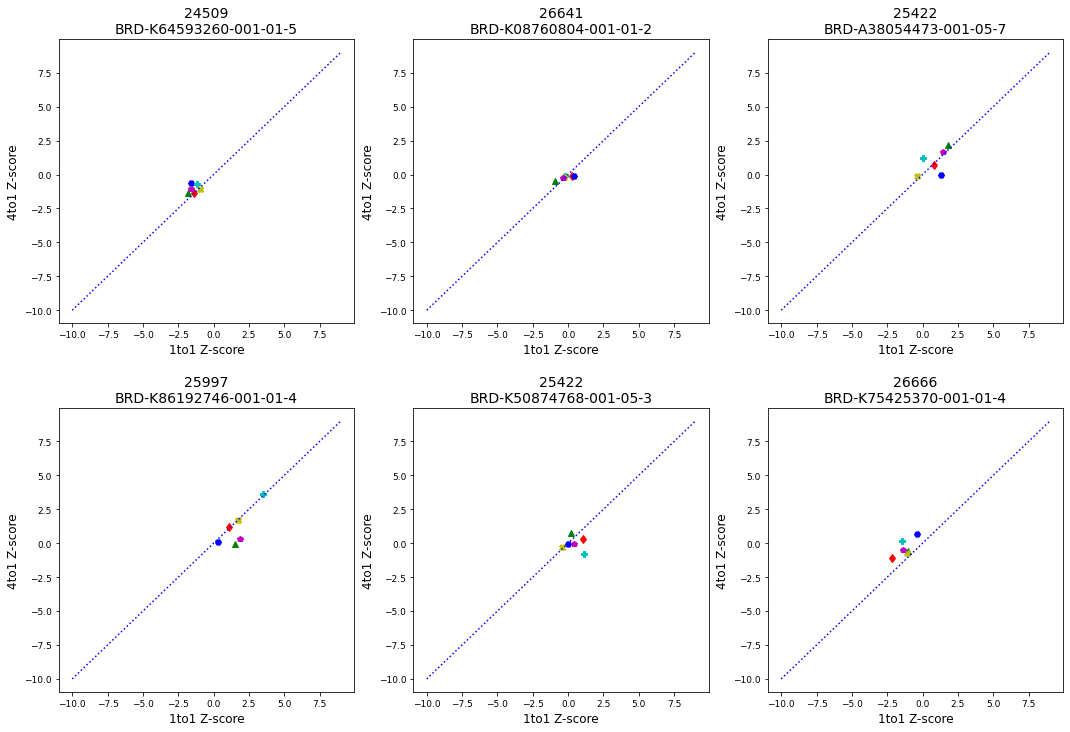

In [35]:
from random import sample

markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
nrows = 2
ncols = 3
metric = 'MSE'
mul_m = 1

samples = sample(list(trts.index), nrows*ncols)
# samples = [(25571, 'BRD-K66760553-001-06-3'),
#     (24509, 'BRD-K15876355-001-01-0'),
#     (25945, 'BRD-A52660433-066-01-3'),
#     (25575, 'BRD-K14096728-001-05-7'),
#     (26622, 'BRD-K07982814-001-01-1'),
#     (24321, 'BRD-K67439147-001-01-7')]
# samples = [(24311, 'BRD-K52313696-001-01-6'),
#             (25985, 'BRD-K52313696-001-01-6'),
#             (25987, 'BRD-K52313696-001-01-6')]
d={'xlabel':"1to1 Z-score", 'ylabel':"4to1 Z-score"}

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6), sharey=True, sharex=True, subplot_kw=d, facecolor='white')
fig.subplots_adjust(hspace=0.3, wspace=0.2)
# fig.suptitle(f'Comapring Z-score - raw features vs. mappings', fontsize = 24)

symbols = [0,0,0,0,0,0]
for i, sample in enumerate(samples):
    z_scores = trts[trts.index.isin([sample])]


#     cols = zip(z_features.columns, z_mapping.columns)
    for j, chan in enumerate(['AGP', 'DNA', 'ER', 'Mito', 'RNA']):
        symbols[j] = ax[i%nrows, i//nrows].plot(z_scores[f'{chan}_{metric}_1to1']*mul_m, z_scores[f'{chan}_{metric}_4to1']*mul_m, f'{colors[j]}{markers[j]}')[0]
        
    symbols[-1] = ax[i%nrows, i//nrows].plot(z_scores[f'ALL_{metric}_1to1']*mul_m, z_scores[f'ALL_{metric}_4to1']*mul_m, f'{colors[-1]}{markers[-1]}')[0]

    ax[i%nrows, i//nrows].plot(range(-10, 10),range(-10, 10), 'b:')
#     ax[i%nrows, i//nrows].set(xlim=(-10, 130), ylim=(-10, 130))
#     ax[i%nrows, i//nrows].set_yscale('symlog')
#     ax[i%nrows, i//nrows].set_xscale('symlog')
    ax[i%nrows, i//nrows].set_title(f'{sample[0]}\n{sample[1]}', )
    ax[i%nrows, i//nrows].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i%nrows, i//nrows].tick_params(axis='both', labelsize = 9)
    ax[i%nrows, i//nrows].yaxis.label.set_size(12)
    ax[i%nrows, i//nrows].xaxis.label.set_size(12)
    ax[i%nrows, i//nrows].title.set_size(14)
    
# handles, labels = ax[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# fig.legend(symbols, ['AGP', 'DNA', 'ER', 'Mito', 'RNA', 'ALL'], markerscale=1.2, fontsize='x-large')
# fig.savefig(f'{plots_path}/final_compounds.png')

plt.show()